In [1]:
# Essentials
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Importing activation functions
from activation_functions import tanh, tanh_derivative, sigmoid, sigmoid_derivative, relu, relu_derivative
from initializers import xavier, he

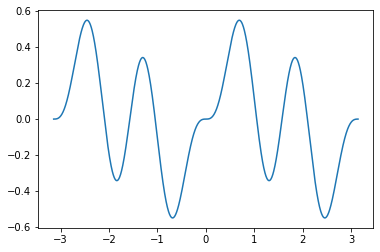

In [2]:
# Creating the dataset 
X = np.arange(-np.pi, np.pi, 0.005)
y = np.sin(X) * np.sin(2 * X) * np.sin(3 * X)
plt.plot(X, y);
plt.show();
X = X.reshape(1257, 1)
y = y.reshape(1257, 1)

In [3]:
# defining a neural network
class NeuralNetwork:
    '''To create a NeuralNetwork object you need features X, Label y and the number of neurons in each hidden layer.'''
    def __init__(self, X, y, layers_length, activation='Relu', objective='regression'):
        self.input = X
        self.layers_length = layers_length
        
        # Initializing weights according to the activation function
        if activation == 'tanh':
            self.weights1 = xavier(self.input.shape[1] ,layers_length[0])
            self.weights = []
            for index, layer in enumerate(layers_length):
                if index != 0:
                    self.weights.append(xavier(layers_length[index-1] + 1,layers_length[index]))
            self.last_weights = xavier(layers_length[-1] + 1, y.shape[1])
        elif activation =='sigmoid':
            self.weights1 = xavier(self.input.shape[1] ,layers_length[0]) * 3.6
            self.weights = []
            for index, layer in enumerate(layers_length):
                if index != 0:
                    self.weights.append(xavier(layers_length[index-1] + 1,layers_length[index]) * 3.6) 
            self.last_weights = xavier(layers_length[-1] + 1, y.shape[1]) * 3.6
        elif activation == 'Relu':
            self.weights1 = he(self.input.shape[1] ,layers_length[0])
            self.weights = []
            for index, layer in enumerate(layers_length):
                if index != 0:
                    self.weights.append(he(layers_length[index-1] + 1,layers_length[index]))
            self.last_weights = he(layers_length[-1] + 1, y.shape[1])
        
        self.output = np.zeros(y.shape)
        self.y = y
        self.activation = activation
        self.objective = objective
        
    def __activation_func(self):
        activation_options = {
            'tanh': (tanh, tanh_derivative),
            'sigmoid': (sigmoid, sigmoid_derivative),
            'Relu': (relu, relu_derivative)
        }
        return activation_options[self.activation]
                

    def __feedforward(self):
        activation = self.__activation_func()[0]
        bias1 = np.ones((self.input.shape[0], 1))
        self.z1 = np.concatenate((np.dot(self.input, self.weights1), bias1), axis=1)
        self.layer1 = activation(self.z1)
        self.layers = [self.layer1]
        self.zs = [self.z1]
        for weight in self.weights:
            prev_layer =self.layers[-1]
            bias = np.ones((prev_layer.shape[0], 1))
            z = np.concatenate((np.dot(prev_layer, weight), bias), axis=1)
            layer = activation(z)
            self.layers.append(layer)
            self.zs.append(z)
        self.z_last = np.dot(self.layers[-1], self.last_weights)
        self.output = self.z_last if self.objective == 'regression' else activation(self.z_last)
        return self.output
    
    def __backprop(self):
        derivative = self.__activation_func()[1]
        delta_last = 2 * (self.y - self.output) if self.objective == 'regression' else derivative(2 * (self.y - self.output))
        d_last_weights = np.dot(self.layers[-1].T, delta_last)
        
        deltas = [delta_last]
        d_weights = []
        for index in reversed(range(len(self.weights))):
            if index < len(self.weights) - 1:
                delta = np.dot(deltas[-1][:,:-1], self.weights[index+1].T) * derivative(self.zs[index+1])
            else:
                delta = np.dot(deltas[-1], self.last_weights.T) * derivative(self.zs[index+1])
            if index != 0:
                d_weights.append(np.dot(self.layers[index].T, delta))
            else: 
                d_weights.append(np.dot(self.layer1.T, delta))
            deltas.append(delta)
            
        if self.weights == []:
            d_weights1 = np.dot(self.input.T, np.dot(deltas[-1], self.last_weights.T) * derivative(self.z1))
        else:
            d_weights1 = np.dot(self.input.T, np.dot(deltas[-1][:,:-1], self.weights[0].T) * derivative(self.z1))
        
        self.last_weights += self.learning_rate * d_last_weights
        for index in reversed(range(len(self.weights))):
            self.weights[len(self.weights) - index - 1] += self.learning_rate * d_weights[index][:, :-1]
        self.weights1 += self.learning_rate * d_weights1[:, :-1]
        
    def compile(self, learning_rate):
        self.learning_rate = learning_rate
        
    def train(self, epochs=1000):
        history = []
        for i in range(epochs + 1):
            history.append(np.mean(np.square(y - self.output)))
            output = self.__feedforward()
            if (i % (epochs // 10) == 0):
                print("epoch {}".format(i))
                print("loss: {}".format(np.mean(np.square(y - self.output))))
                print("-----------------------------------------------------")
            self.__backprop()
        return history
        
    def predict(self):
        return self.__feedforward()
        
    def summary(self):
        '''Providesss a quick summary of the model'''
        if self.input.shape[1] > 1:
            print("Input layer has {} neurons.".format(self.input.shape[1]))
        else:
            print("Input layer has 1 neuron.")
        print("Weight matrix 1 has {} shape.".format(self.weights1.shape))
        for index in range(len(self.layers_length)):
            print("Hidden layer {} has {} neurons.".format(index+1, self.layers_length[index]))
            if index < len(self.weights):
                print("Weight matrix {} has {} shape.".format(index+2, self.weights[index].shape))
        print("Weight matrix {} has {} shape.".format(index+2, self.last_weights.shape))
        if self.output.shape[1] > 1:
            print("Output layer has {} neurons.".format(self.output.shape[1]))
        else:
            print("Output layer has 1 neuron.")

In [4]:
NN = NeuralNetwork(X, y, [128, 128, 128, 128], activation='Relu')
NN.summary()
NN.compile(0.0001)

Input layer has 1 neuron.
Weight matrix 1 has (1, 128) shape.
Hidden layer 1 has 128 neurons.
Weight matrix 2 has (129, 128) shape.
Hidden layer 2 has 128 neurons.
Weight matrix 3 has (129, 128) shape.
Hidden layer 3 has 128 neurons.
Weight matrix 4 has (129, 128) shape.
Hidden layer 4 has 128 neurons.
Weight matrix 5 has (129, 1) shape.
Output layer has 1 neuron.


In [5]:
r = NN.train(epochs=10000)

epoch 0
loss: 0.15366526446564366
-----------------------------------------------------
epoch 1000
loss: 0.04850851741890317
-----------------------------------------------------
epoch 2000
loss: 0.04520236171306234
-----------------------------------------------------
epoch 3000
loss: 0.028972236514894
-----------------------------------------------------
epoch 4000
loss: 0.02445068581679235
-----------------------------------------------------
epoch 5000
loss: 0.0139479609499139
-----------------------------------------------------
epoch 6000
loss: 0.010754188518665999
-----------------------------------------------------
epoch 7000
loss: 0.008495850713341715
-----------------------------------------------------
epoch 8000
loss: 0.008958498670423014
-----------------------------------------------------
epoch 9000
loss: 0.0067119470401115
-----------------------------------------------------
epoch 10000
loss: 0.004421549054963792
-----------------------------------------------------


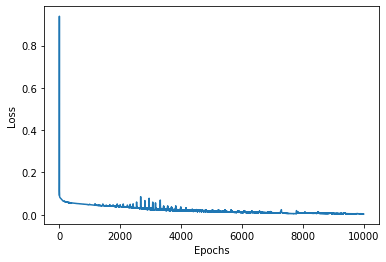

In [6]:
plt.plot(r);
plt.xlabel('Epochs');
plt.ylabel('Loss');

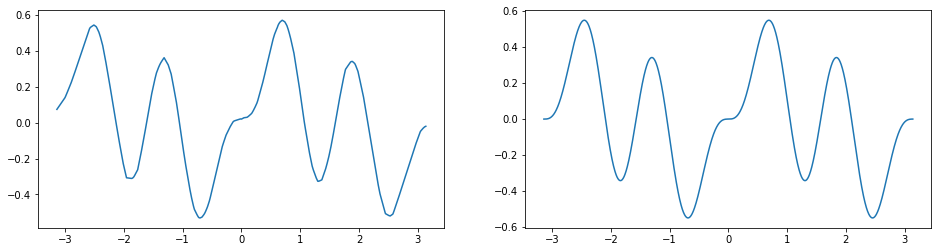

In [7]:
plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
plt.plot(X.reshape(1257), NN.predict().reshape(1257))
plt.subplot(1, 2, 2)
plt.plot(X.reshape(1257), y.reshape(1257))
plt.show()